<a href="https://colab.research.google.com/github/PrzemyslawSarnacki/AirQualityPrediction/blob/master/seasonal_analisys.ipynb" target="_parent">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a> 

## Wstępna obróbka danych

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import numpy as np
import unicodedata
from io import BytesIO
import requests
import joblib


warnings.simplefilter('ignore')
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import tensorflow as tf
import tensorflow_probability as tfp

def strip_accents(text):
    return ''.join(c for c in unicodedata.normalize('NFKD', text.lower().replace("ł","l")) if unicodedata.category(c) != 'Mn')

CITIES = ["Warszawa", "Kraków", "Poznań", "Katowice", "Białystok"]
COORDINATES = {
    "warszawa": {
        "latitude": 52.2297,
        "longitude": 21.0122
    },
    "krakow": {
        "latitude": 50.0647,
        "longitude": 19.9450
    },
    "poznan": {
        "latitude": 52.4064,
        "longitude": 16.9252
    },
    "katowice": {
        "latitude": 50.2649,
        "longitude": 19.0238
    },
    "bialystok": {
        "latitude": 53.1325,
        "longitude": 23.1688
    },
}
PARAMETERS = ['pm25', 'pm10', 'no2', 'so2', 'o3', 'co']

indices = [""] + [f".{i}" for i in range(1, 6)]
data = {}

df = pd.read_csv("https://raw.githubusercontent.com/PrzemyslawSarnacki/AirQualityPrediction/master/data/airq_data_1.csv", index_col=0, parse_dates=True)

# load machine learning model for aqi prediction
m_link = 'https://github.com/PrzemyslawSarnacki/AirQualityPrediction/blob/master/data/aqi.joblib?raw=true'
m_file = BytesIO(requests.get(m_link).content)
aqi_model = joblib.load(m_file)

# fill columns with data
for city in CITIES:
    data[strip_accents(city)] = pd.DataFrame(df, columns=[f"{strip_accents(city)}{item}" for item in indices])
    data[strip_accents(city)] = data[strip_accents(city)].rename(columns=data[strip_accents(city)].iloc[0]).drop(data[strip_accents(city)].index[0])
    data[strip_accents(city)] = data[strip_accents(city)].drop(index="date.local").astype(float).interpolate(method="linear")
    data[strip_accents(city)].index = pd.to_datetime(data[strip_accents(city)].index)
    data[strip_accents(city)]["aqi"] = aqi_model.predict(data[strip_accents(city)].fillna(0))


In [3]:
# create columns with seasonal features
data["katowice"]['day_of_month'] = data["katowice"].index.day
data["katowice"]['month'] = data["katowice"].index.month
data["katowice"]['day_of_week'] = data["katowice"].index.dayofweek
data["katowice"]['daysinmonth'] = data["katowice"].index.daysinmonth

# split data for training and test
threshold_date = pd.to_datetime('2020-07-01')
mask = data["katowice"].index < threshold_date
df_train = data["katowice"][mask]
df_test = data["katowice"][~ mask]

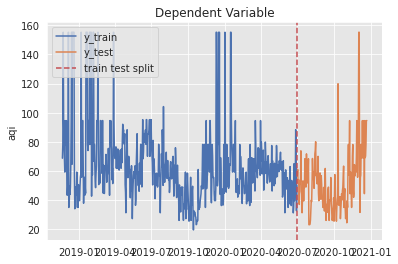

In [4]:
fig, ax = plt.subplots()
sns.lineplot(x=df_train.index, y='aqi', label='y_train', data=df_train, ax=ax)
sns.lineplot(x=df_test.index, y='aqi', label='y_test', data=df_test, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper left')
ax.set(title='Dependent Variable');

# Analiza i dekompozycja szeregów czasowych

Przy pomocy filtru Gaussa wygładzimy krzywą. Jest to średnia ruchoma oparta na rozkładzie normalnym

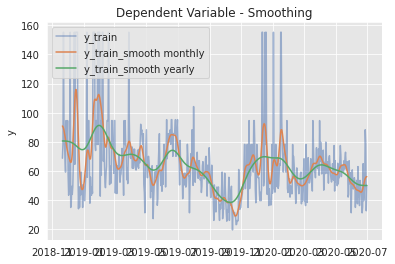

In [5]:
from scipy.ndimage import gaussian_filter
# smoothing the curve
df_smooth = df_train \
    .assign(y_smooth_1 = lambda x: gaussian_filter(input=x['aqi'], sigma=3.5)) \
    .assign(y_smooth_2 = lambda x: gaussian_filter(input=x['aqi'], sigma=15)) \

fig, ax = plt.subplots()
sns.lineplot(x=df_smooth.index, y='aqi', label='y_train', data=df_smooth, alpha=0.5, ax=ax)
sns.lineplot(x=df_smooth.index, y='y_smooth_1', label='y_train_smooth monthly', data=df_smooth, ax=ax)
sns.lineplot(x=df_smooth.index, y='y_smooth_2', label='y_train_smooth yearly', data=df_smooth, ax=ax)
ax.legend(loc='upper left')
ax.set(title='Dependent Variable - Smoothing', ylabel='y');

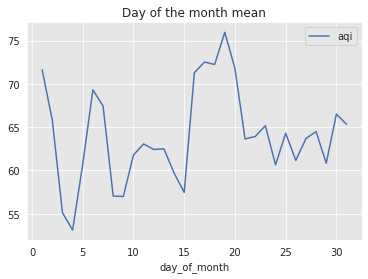

In [6]:
fig, ax = plt.subplots()
df_train.groupby('day_of_month').agg({'aqi': np.mean}).plot(ax=ax)
ax.set(title='Day of the month mean');

Usuńmy dwa komponenty sezonowe (roczny i miesięczny)

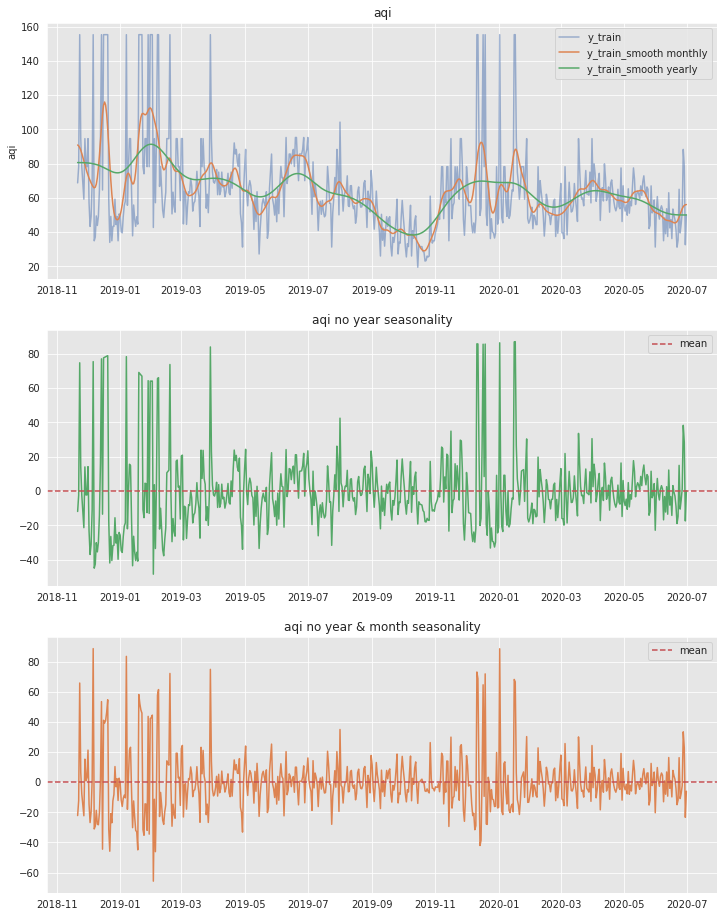

In [7]:
# Remove yearly seasonality.
y_no_year_season = df_smooth['aqi'] - df_smooth['y_smooth_2']
# Remove monthly seasonality.
y_no_year_month_season = y_no_year_season \
    - gaussian_filter(input=y_no_year_season, sigma=3.5)

# Plot components.
fig, ax = plt.subplots(3, 1, figsize=(12, 16))
sns.lineplot(x=df_smooth.index, y='aqi', label='y_train', data=df_smooth, alpha=0.5, ax=ax[0])
sns.lineplot(x=df_smooth.index, y='y_smooth_1', label='y_train_smooth monthly', data=df_smooth, ax=ax[0])
sns.lineplot(x=df_smooth.index, y='y_smooth_2', label='y_train_smooth yearly', data=df_smooth, ax=ax[0])
ax[0].set(title='aqi')

ax[1].plot(df_smooth.index, y_no_year_season, c=sns_c[2])
ax[1].axhline(y_no_year_season.mean(), color=sns_c[3], linestyle='--', label='mean')
ax[1].legend()
ax[1].set(title='aqi no year seasonality')

ax[2].plot(df_smooth.index, y_no_year_month_season, c=sns_c[1])
ax[2].axhline(y_no_year_month_season.mean(), color=sns_c[3], linestyle='--', label='mean')
ax[2].legend()
ax[2].set(title='aqi no year & month seasonality');

Obliczmy teraz autokorelację i częściową autokorelację. Jak widzimy możemu zaobserwować sezonowość z opóźnieniem 9. Kształt wykresu pokazuje nam również, że kodowanie jest cykliczne. 

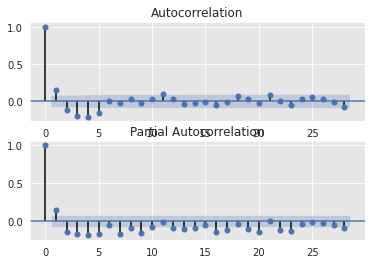

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2, 1)
plot_acf(x=y_no_year_month_season, ax=ax[0])
plot_pacf(x=y_no_year_month_season, ax=ax[1]);

In [9]:
np.corrcoef(df_train['aqi'], df_train['pm25'])[0, 1]

0.737325930139337

In [10]:
np.corrcoef(y_no_year_month_season, df_train['pm25'])[0, 1]

0.5048681881124695

W tym momencie pozostało nam usunięcie tygodniowej sezonowości. Jak widzimy mamy pewne zbiory na każdym poziomie

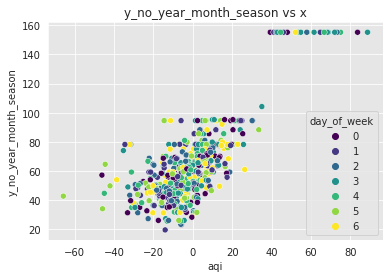

In [11]:
fig, ax = plt.subplots()
sns.scatterplot(
    x=y_no_year_month_season, 
    y=df_train['aqi'], 
    hue=data["katowice"]['day_of_week'],
    palette='viridis',
    ax=ax, 
)

ax.set(
    title='y_no_year_month_season vs x', 
    xlabel='aqi', 
    ylabel='y_no_year_month_season'
);

Przygotujmy dane do zastosowania na nich regresji liniowej. Użyjemy tutaj tzw. techniki one-hot encoding czyli podzielimy konkretne dni tygodnia na poszczególne kolumny. 

In [12]:
# Prepare model data frame.
dow_df = df_train[['day_of_week']].copy()
dow_df['y_no_year_month_season'] = y_no_year_month_season
# One-hot encoding of the day of the week.
dow_dummies = pd.get_dummies(dow_df['day_of_week'], drop_first=True)
dow_dummies.columns = ['d' + str(i) for i in dow_dummies.columns]
dow_df = pd.concat([dow_df, dow_dummies], axis=1)
dow_df.head()

,day_of_week,y_no_year_month_season,d1,d2,d3,d4,d5,d6
2018-11-21,2,-22.136176,0,1,0,0,0,0
2018-11-22,3,-12.191378,0,0,1,0,0,0
2018-11-23,4,65.901233,0,0,0,1,0,0
2018-11-24,5,6.704433,0,0,0,0,1,0
2018-11-25,6,-7.779388,0,0,0,0,0,1


Teraz dopasujmy model regresji liniowej

In [13]:
import statsmodels.formula.api as smf

dow_mod = smf.ols(
    formula='y_no_year_month_season ~  d1 + d2 + d3 + d4 + d5 + d6', 
    data=dow_df
)

dow_res = dow_mod.fit()

print(dow_res.summary())

                              OLS Regression Results                              
Dep. Variable:     y_no_year_month_season   R-squared:                       0.012
Model:                                OLS   Adj. R-squared:                  0.002
Method:                     Least Squares   F-statistic:                     1.163
Date:                    Tue, 16 Feb 2021   Prob (F-statistic):              0.325
Time:                            17:38:20   Log-Likelihood:                -2557.8
No. Observations:                     588   AIC:                             5130.
Df Residuals:                         581   BIC:                             5160.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

Jak widzimy korelacja uległa zwiększeniu 

In [14]:
np.corrcoef(dow_res.resid, df_train['pm10'])[0, 1]

0.5230630606086926

Możemy również oszacować jaki jest efekt regresora (czyli pm10). Otrzymamy to dopasowując pozostałości poprzedniego modelu

In [15]:
x_df = df_train[['pm10']].copy()
x_df['dow_model_resid'] = dow_res.resid

x_mod = smf.ols(formula='dow_model_resid ~ pm10', data=x_df)

x_res = x_mod.fit()

print(x_res.summary())

                            OLS Regression Results                            
Dep. Variable:        dow_model_resid   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     220.7
Date:                Tue, 16 Feb 2021   Prob (F-statistic):           1.33e-42
Time:                        17:38:21   Log-Likelihood:                -2463.8
No. Observations:                 588   AIC:                             4932.
Df Residuals:                     586   BIC:                             4940.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -15.5942      1.240    -12.577      0.0

Jak widzimy efekt ten wynosi jedynie około 0.46

In [16]:
x_res.params['pm10']

0.46132300120830416

Możemy pewne właściwości sezonowe wyodbrębnić przy pomocy widmowej gęstości mocy

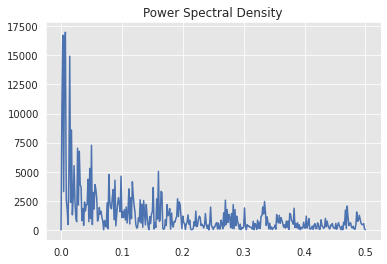

In [17]:
from scipy import signal

f, Pxx_den = signal.periodogram(
    x=df_train['aqi'], 
    detrend='linear', 
    nfft=int(7e2)
)

fig, ax = plt.subplots()
sns.lineplot(x=f, y=Pxx_den, ax=ax)
ax.set(title='Power Spectral Density');

Po posortowaniu wszystkich maksimów lokalnych i obliczeniu dnia możemy zauważyć, że mamy co dwumiesięczną i coroczną sezonowość tych danych

In [18]:
# Sort to get the peak values.
sort_freq_index = np.argsort(a=Pxx_den)[::-1]

periodogram_df = pd.DataFrame(
    {'sort_freq': f[sort_freq_index], 'Pxx_den': Pxx_den[sort_freq_index]}
)

periodogram_df.assign(days = lambda x: 1/x['sort_freq']).head(5)

,sort_freq,Pxx_den,days
0,0.007143,16980.100026,140.0
1,0.002857,16727.894776,350.0
2,0.005714,15646.661359,175.0
3,0.014286,14926.769976,70.0
4,0.001429,10688.534606,700.0


In [19]:
df_train["date"] = df_train.index

Możemy zdekomponować nasz szereg czasowy przy pomocy funkcji seasonal_decompose 

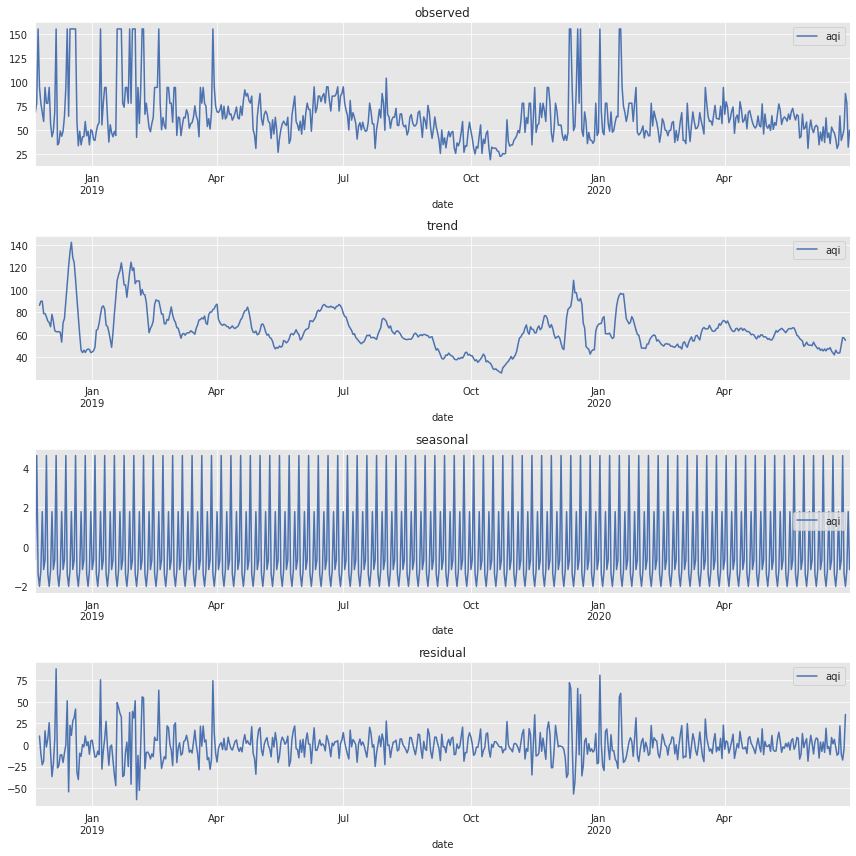

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_obj = seasonal_decompose(
    x=df_train[['date', 'aqi']].set_index('date'), 
    model='additive'
)

fig, ax = plt.subplots(4, 1, figsize=(12, 12))

decomposition_obj.observed.plot(ax=ax[0])
ax[0].set(title='observed')
decomposition_obj.trend.plot(ax=ax[1])
ax[1].set(title='trend')
decomposition_obj.seasonal.plot(ax=ax[2])
ax[2].set(title='seasonal')
decomposition_obj.resid.plot(ax=ax[3])
ax[3].set(title='residual')
plt.tight_layout()

In [21]:
x_df['decomposition_resid'] = decomposition_obj.resid.values

x_mod2 = smf.ols(formula='decomposition_resid ~ pm10', data=x_df[3:-3])

x_res2 = x_mod2.fit()

print(x_res2.summary())

                             OLS Regression Results                            
Dep. Variable:     decomposition_resid   R-squared:                       0.223
Model:                             OLS   Adj. R-squared:                  0.222
Method:                  Least Squares   F-statistic:                     166.5
Date:                 Tue, 16 Feb 2021   Prob (F-statistic):           1.16e-33
Time:                         17:38:23   Log-Likelihood:                -2427.5
No. Observations:                  582   AIC:                             4859.
Df Residuals:                      580   BIC:                             4868.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -13.3781      1.223    -10.94

# Budowa modelu

Zdefiniujmy osobno każdy z komponentów potrzebnych do zbudowania modelu

Będą to kolejno:
*   Liniowy model lokalnego trendu
*   Zmienne sezonowe dotyczące miesięcy roku, dni tygodnia etc.
*   Model regresji liniowej uwzględniający regresor w postaci dni miesiąca
*   Model regresji liniowej uwzględniający regresor w postaci parametru pm10





In [22]:
# Local linear trend. 
local_linear_trend = tfp.sts.LocalLinearTrend(
    observed_time_series=df_train['aqi'].astype(np.float32), 
    name='local_linear_trend',
)

# We need to pre-define the number of days in each month.
num_days_per_month = np.array(
  [
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
    [31, 28, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31],
    [31, 29, 31, 30, 30, 31, 31, 31, 30, 31, 30, 31] # year with leap day.
  ] 
)  

# Define month of year seasonal variable.
month_of_year = tfp.sts.Seasonal(
  num_seasons=12,
  num_steps_per_season=num_days_per_month,
  name='month_of_year'
)

# Define day of week as seasonal variable.
day_of_week = tfp.sts.Seasonal(
    num_seasons=7,
    num_steps_per_season=1,
    observed_time_series=df_train['aqi'].astype(np.float32), 
    name='day_of_week',
)

# Create cyclic variable for day of the month.
design_matrix_day_of_month = tf.reshape(
    np.sin(2*np.pi*data["katowice"]['day_of_month'] / data["katowice"]['daysinmonth']).values.astype(np.float32), 
    (-1, 1)
)

# Define day of the month as an external regressor.
# We do not encode it as seasonal as the number of steps is not uniform.
day_of_month = tfp.sts.LinearRegression(
    design_matrix=design_matrix_day_of_month,
    name='day_of_month'
)

# Define external regressor component. 
# We use the whole data set (df) as we expect to have these values in the future. 
design_matrix_x_var = tf.reshape(data["katowice"]['pm10'].values.astype(np.float32), (-1, 1))

x_var = tfp.sts.LinearRegression(
    design_matrix=design_matrix_x_var,
    name='x_var'
)

Instructions for updating:
Do not call `graph_parents`.
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


Budujemy model i zadajemy mu dane treningowe

In [23]:
model_components = [
    local_linear_trend, 
    month_of_year, 
    day_of_week, 
    day_of_month, 
    x_var,
]

toy_model = tfp.sts.Sum(
    components=model_components, 
    observed_time_series=df_train['aqi'].astype(np.float32)
    )

# Dopasowanie modelu

Zbudujemy model a posterriori, który uwzględnia parametry modelu.

In [24]:
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=toy_model, seed=42)
q_prior_samples = variational_posteriors.sample(1000)

Rozkłady a priori (przed optymalizacją)

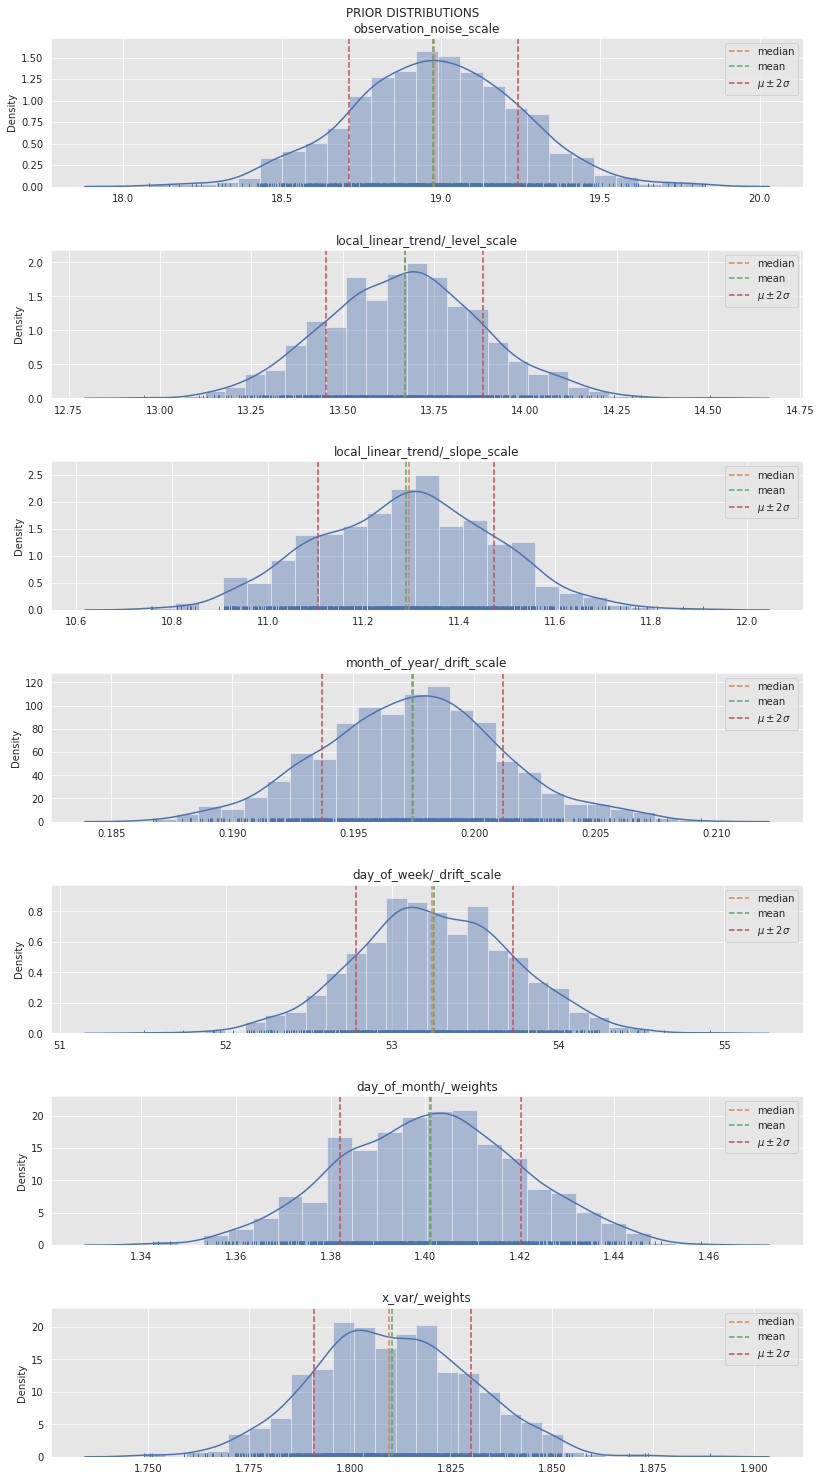

In [25]:
num_parameters = len(toy_model.parameters)

fig, ax = plt.subplots(num_parameters, 1, figsize=(12, 21))

for i, param in enumerate(toy_model.parameters):
    
    param_mean = np.mean(q_prior_samples[param.name], axis=0)
    param_median = np.median(q_prior_samples[param.name], axis=0)
    param_std = np.std(q_prior_samples[param.name], axis=0)
    
    sns.distplot(a=q_prior_samples[param.name], rug=True, ax=ax[i])
    ax[i].set(title=param.name)
    ax[i].axvline(x= param_median, color=sns_c[1], linestyle='--', label='median')
    ax[i].axvline(x= param_mean, color=sns_c[2], linestyle='--', label='mean')
    ax[i].axvline(x= param_mean + param_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
    ax[i].axvline(x= param_mean - param_std, color=sns_c[3], linestyle='--')
    ax[i].legend()
    
plt.tight_layout(pad=3.0)
plt.suptitle('PRIOR DISTRIBUTIONS', y=0.99);

Następnie uruchamiamy procedurę optymalizacji. Użyjemy tutaj algorytm adaptacyjnej prędkości uczenia (adaptive learning rate) o nazwie Adam oraz wykonamy proces trenowania naszego modelu 

In [26]:
num_variational_steps = int(200)

# Set optimizer.
optimizer = tf.optimizers.Adam(learning_rate=0.1)

# Using fit_surrogate_posterior to build and optimize 
# the variational loss function.
@tf.function(experimental_compile=True)
def train():
    # Build the joint density. 
    target_log_prob_fn = toy_model.joint_log_prob(
        observed_time_series=df_train['aqi'].astype(np.float32)
    )
    
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=target_log_prob_fn,
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps,
        seed=42
    )
    
    return elbo_loss_curve

# Run optimization.
elbo_loss_curve = train()

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


Narysujmy krzywą ELBO Loss (ELBO z ang. evidence lower bound, czyli dolna granica dowodu), która świadczy o (nie)dokładności naszego modelu. Jak możemy zauważyć udało nam się osiągnąć wartość minimalną  

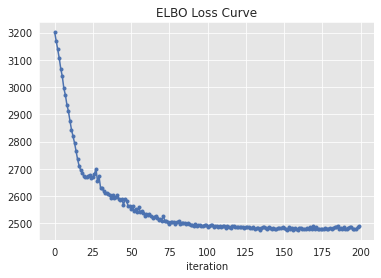

In [27]:
fig, ax = plt.subplots()
ax.plot(elbo_loss_curve, marker='.')
ax.set(title='ELBO Loss Curve', xlabel='iteration');

In [28]:
q_samples = variational_posteriors.sample(1000)
num_parameters = len(toy_model.parameters)


Rozkłady po optymalizacji :

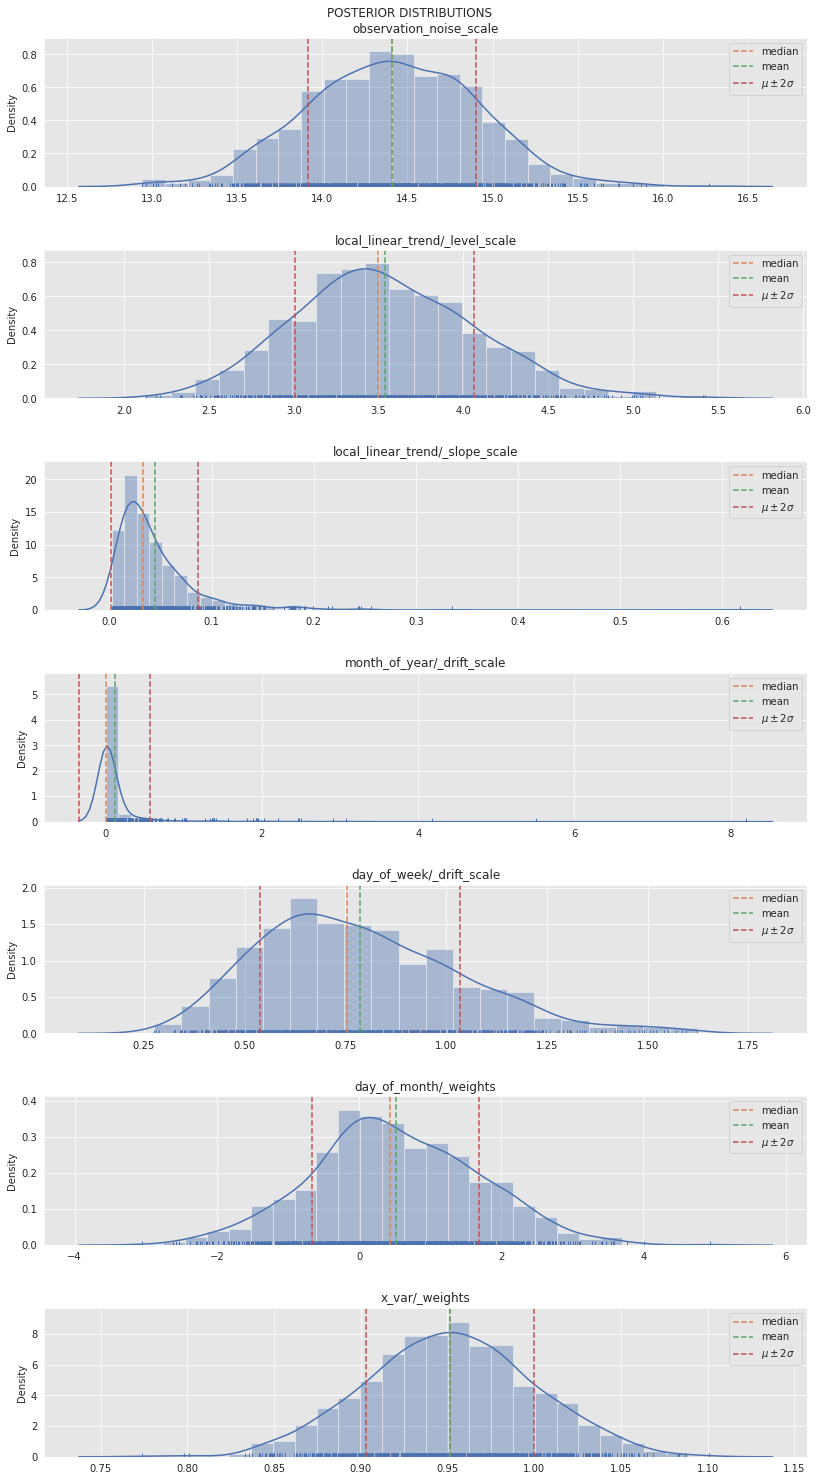

In [29]:
num_parameters = len(toy_model.parameters)

fig, ax = plt.subplots(num_parameters, 1, figsize=(12, 21))

for i, param in enumerate(toy_model.parameters):
    
    param_mean = np.mean(q_samples[param.name], axis=0)
    param_median = np.median(q_samples[param.name], axis=0)
    param_std = np.std(q_samples[param.name], axis=0)
    
    sns.distplot(a=q_samples[param.name], rug=True, ax=ax[i])
    ax[i].set(title=param.name)
    ax[i].axvline(x= param_median, color=sns_c[1], linestyle='--', label='median')
    ax[i].axvline(x= param_mean, color=sns_c[2], linestyle='--', label='mean')
    ax[i].axvline(x= param_mean + param_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
    ax[i].axvline(x= param_mean - param_std, color=sns_c[3], linestyle='--')
    ax[i].legend()
    
plt.tight_layout(pad=3.0)
plt.suptitle('POSTERIOR DISTRIBUTIONS', y=0.99);


In [30]:
# Get mean and std for each parameter.
print('Inferred parameters:')
for param in toy_model.parameters:
    print('{}: {} +- {}'.format(
        param.name,
        np.mean(q_samples[param.name], axis=0),
        np.std(q_samples[param.name], axis=0))
    )

Inferred parameters:
observation_noise_scale: 14.410150527954102 +- 0.4942472577095032
local_linear_trend/_level_scale: 3.5371148586273193 +- 0.5279334783554077
local_linear_trend/_slope_scale: 0.04429551586508751 +- 0.042471371591091156
month_of_year/_drift_scale: 0.11750862002372742 +- 0.45481351017951965
day_of_week/_drift_scale: 0.7864148616790771 +- 0.24811163544654846
day_of_month/_weights: [0.5133519] +- [1.1683118]
x_var/_weights: [0.9514525] +- [0.04821954]


## Przewidywanie 

W tym momencie wygenerujemy prognozę Air Quality Index dla ostatnich 6 miesięcy roku 2020 

In [31]:
# Compute number of days in the last 6 months of 2020.
forecast_window = num_days_per_month[-1][6:13].sum() - 9

# Get forecast distribution.
forecast_dist = tfp.sts.forecast(
    toy_model,
    observed_time_series=df_train['aqi'].astype(np.float32),
    parameter_samples=q_samples,
    num_steps_forecast=forecast_window.astype(np.int32)
)

Na podstawie otrzymanego wyniku obliczamy średnią i odchylenia standardowe

In [32]:
# Sample and compute mean and std. 
num_samples = 100

forecast_mean, forecast_scale, forecast_samples = (
    forecast_dist.mean().numpy().flatten(),
    forecast_dist.stddev().numpy().flatten(),
    forecast_dist.sample(num_samples).numpy().flatten()
)

In [33]:
df_test['y_pred'] = forecast_mean
df_test['y_pred_std'] = forecast_scale
df_test['errors'] = df_test['aqi'] - df_test['y_pred']

Przedstawmy wynik naszego modelu na wykresie

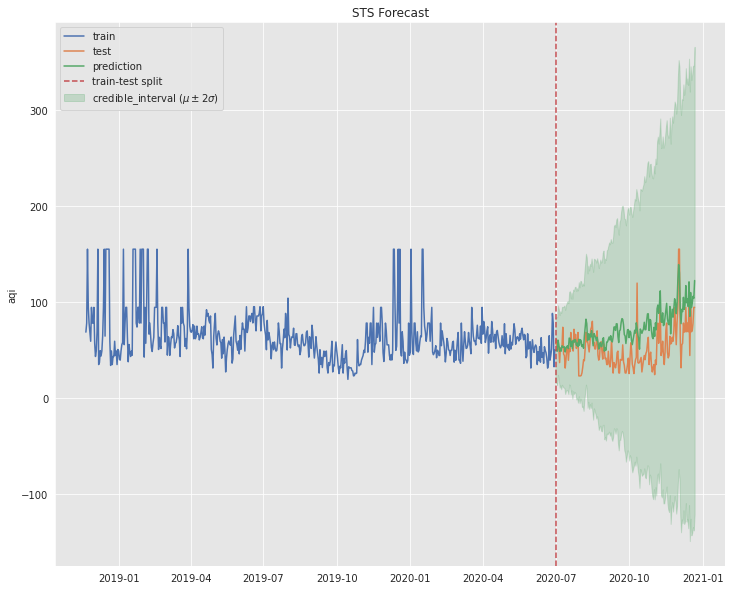

In [34]:
fig, ax = plt.subplots(figsize= (12, 10))

ax.fill_between(
    x=df_test.index,
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)

sns.lineplot(x=df_train.index, y='aqi', label='train', data=df_train, ax=ax)
sns.lineplot(x=df_test.index, y='aqi', label='test', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.axvline(x= threshold_date, color=sns_c[3], linestyle='--', label='train-test split')
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

Okres przewidywany z danymi rzeczywistymi w przybliżeniu 

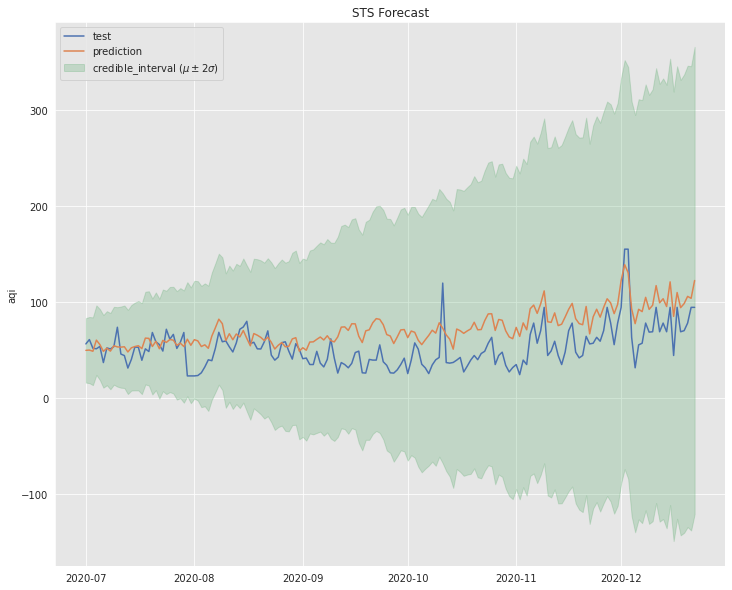

In [35]:
fig, ax = plt.subplots(figsize= (12, 10))

ax.fill_between(
    x=df_test.index,
    y1=df_test['y_pred']-2*df_test['y_pred_std'],
    y2=df_test['y_pred']+2*df_test['y_pred_std'],
    color=sns_c[2], 
    alpha=0.25,
    label=r'credible_interval ($\mu \pm 2\sigma$)'
)
sns.lineplot(x=df_test.index, y='aqi', label='test', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

Przedstawienie korelacji między predykcjami, a wartościami rzeczywistymi

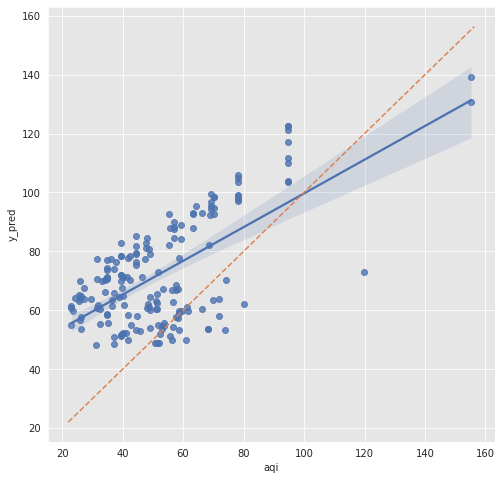

In [36]:
fig, ax = plt.subplots(figsize=(8,8))

# Generate diagonal line to plot. 
d_x = np.linspace(start=df_test['aqi'].min() - 1, stop=df_test['aqi'].max() + 1, num=100)
sns.regplot(x='aqi', y='y_pred', data=df_test, ax=ax)
sns.lineplot(x=d_x, y=d_x, dashes={'linestyle': ''}, ax=ax)
ax.lines[1].set_linestyle('--')

Przy pomocy funkcji one_step_predictive zbadamy anomalie występujące w przedziale przewidywanym


In [37]:
toy_one_step_dist = tfp.sts.one_step_predictive(
    toy_model,
    observed_time_series=df_test['aqi'].astype(np.float32),
    parameter_samples=q_samples)

toy_one_step_mean, toy_one_step_scale = (
    toy_one_step_dist.mean().numpy(), toy_one_step_dist.stddev().numpy())


Jak widzimy przewidywane wartości zawierają w sobie anomalie w końcowym przedziale predykcji

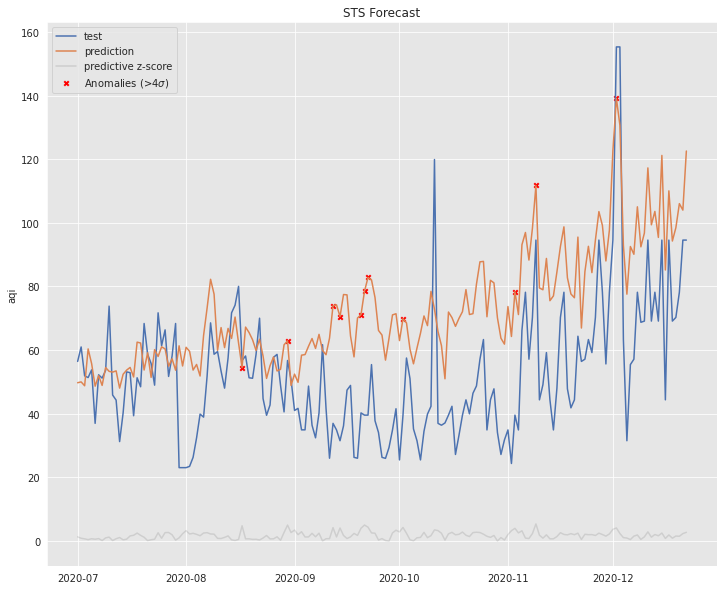

In [47]:
fig, ax = plt.subplots(figsize= (12, 10))

sns.lineplot(x=df_test.index, y='aqi', label='test', data=df_test, ax=ax)
sns.lineplot(x=df_test.index, y='y_pred', label='prediction', data=df_test, ax=ax)
ax.legend(loc='upper left')
ax.set(title='STS Forecast');

zscores = np.abs((df_test['y_pred'] - toy_one_step_mean) /
                 toy_one_step_scale)
anomalies = zscores > 4.0
ax.scatter(df_test.index[anomalies],
           df_test['y_pred'][anomalies],
           c="red", marker="x", s=20, linewidth=2, label=r"Anomalies (>4$\sigma$)")
ax.plot(df_test.index, zscores, color="black", alpha=0.1, label='predictive z-score')
ax.legend()
plt.show()

# Analiza błędów

Sprawdźmy jak wyglądają poszczególne błędy modelu

Błąd średniokwadratowy (Mean Squared Error):

In [39]:
df_test["errors"]

2020-07-01     6.699518
2020-07-02    10.971638
2020-07-03     3.108325
2020-07-04    -8.995327
2020-07-05    -1.953878
                ...    
2020-12-18   -25.157186
2020-12-19   -28.188470
2020-12-20   -27.839438
2020-12-21    -9.420611
2020-12-22   -27.982157
Name: errors, Length: 175, dtype: float64

In [40]:
np.square(df_test["errors"]).mean()

670.8886451469392

Jak widzimy błędy mają postać rozkładu Rayleigha i większość błędów skupia się wokół wartości -40 

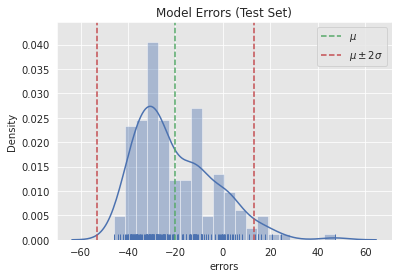

In [41]:
errors_mean = df_test['errors'].mean()
errors_std = df_test['errors'].std()

fig, ax = plt.subplots()

sns.distplot(a=df_test['errors'], ax=ax, bins=20, rug=True)
ax.axvline(x=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$')
ax.axvline(x=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axvline(x=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)');


Autokorelacja

[Text(0.5, 1.0, 'Model Errors (Test Set)')]

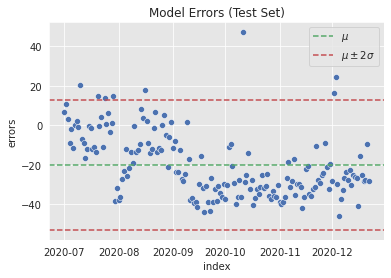

In [42]:
fig, ax = plt.subplots()

sns.scatterplot(x='index', y='errors', data=df_test.reset_index(), ax=ax)
ax.axhline(y=errors_mean, color=sns_c[2], linestyle='--', label=r'$\mu$ ')
ax.axhline(y=errors_mean + 2*errors_std, color=sns_c[3], linestyle='--', label=r'$\mu \pm 2\sigma$')
ax.axhline(y=errors_mean - 2*errors_std, color=sns_c[3], linestyle='--')
ax.legend()
ax.set(title='Model Errors (Test Set)')

Jak widzimy błędy nie występują wg. żadnych powtarzalnych wzorców i są rozdystrybuowane wokół zera

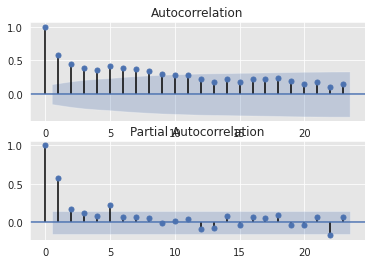

In [43]:
fig, ax = plt.subplots(2, 1)
plot_acf(x=df_test['errors'], ax=ax[0])
plot_pacf(x=df_test['errors'], ax=ax[1]);

# Dekompozycja modelu

Zobaczmy jak wyglądają poszczególne składowe modelu

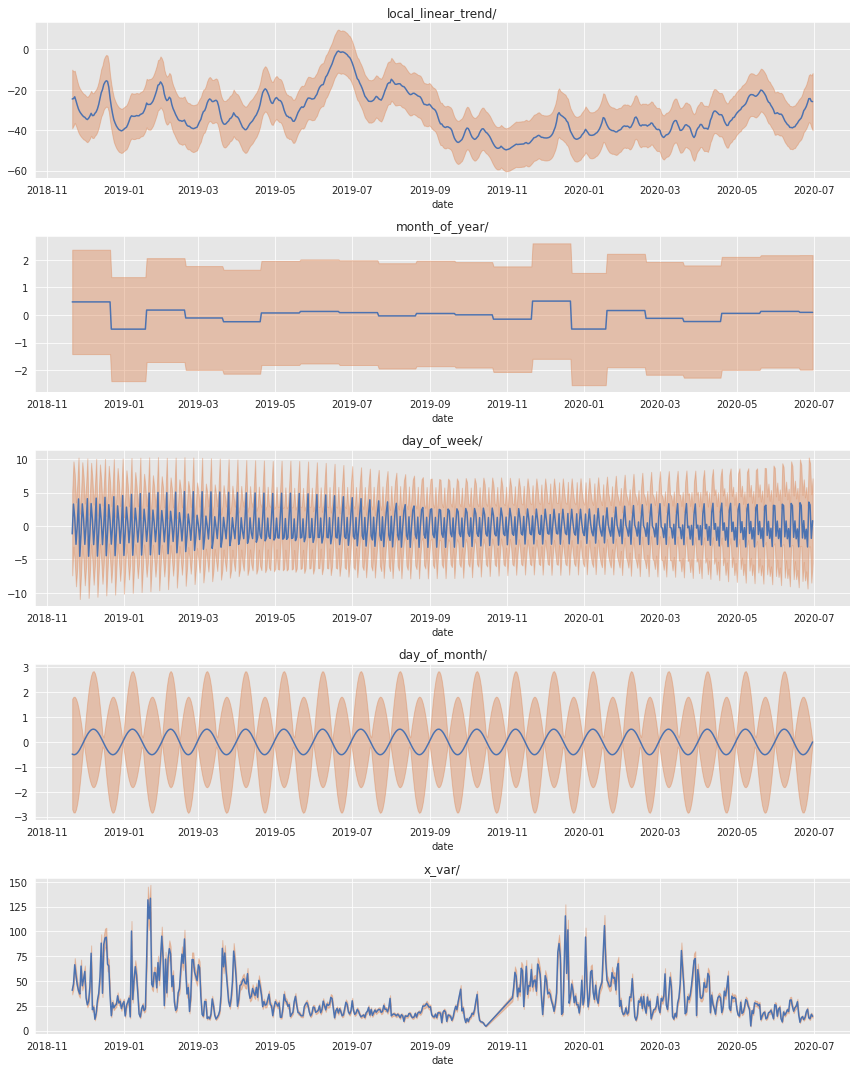

In [44]:
component_dists = tfp.sts.decompose_by_component(
    model=toy_model,
    observed_time_series=df_train['aqi'].astype(np.float32),
    parameter_samples=q_samples
)


component_means, component_stddevs = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)
num_components = len(component_means)

fig, ax = plt.subplots(num_components, 1, figsize= (12, 15))

for i, component_name in enumerate(component_means.keys()):
    component_mean = component_means[component_name]
    component_stddev = component_stddevs[component_name]
    
    sns.lineplot(x=df_train['date'], y=component_mean, color=sns_c[0], ax=ax[i])
    
    ax[i].fill_between(
        x=df_train['date'],
        y1=component_mean-2*component_stddev,
        y2=component_mean+2*component_stddev,
        alpha=0.4, 
        color=sns_c[1]
    )
    
    ax[i].set(title=component_name)

plt.tight_layout()
